## Importing Packages

In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.path.abspath(os.getcwd())))

import numpy as np
import pandas as pd
import cmdstanpy 
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import json
from utils.random import random_rdm_2A
from utils.utils import get_dfs, calculate_waic, bci, plot_mean_posterior
import ipywidgets as widgets

In [2]:
sns.set_theme(style="whitegrid")
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['pdf.use14corefonts'] = True

## Choose Model

#### roots and global variables

In [3]:
root = '../'
plots_root = root + 'Results/Plots/Estimations/'
datasets_root = root + 'Datasets/'
behavioural_data_root = datasets_root +  'behavioral_data/selected_data/' 
stan_files_root = root +  'stan_models/' 
saved_models_root = root + 'Results/stan_results/'

model_config = {}
plots_path = ''
dataset_path = ''
stan_file_path = ''
stan_output_dir = ''

#### read models configuration json file

In [4]:
with open("../models/rdm_models.json") as f:
    models = json.load(f)
    models_name = list(models.keys())
    models_name = list(
        filter(lambda model_name: "individual" in model_name,
               models_name))

#### Choose and set model configuration

In [5]:
def SetModelAndPaths(model_name):
    global model_config
    global plots_path
    global dataset_path
    global stan_file_path
    global stan_output_dir
    model_config = models[model_name]
    plots_path = plots_root + model_config['plots_folder_name'] + '/'
    dataset_path = datasets_root + 'Models Results/' + model_config['dataset_name']
    stan_file_path = stan_files_root + model_config['stan_file']
    stan_output_dir = saved_models_root + model_config['model_name'] + '/'
    
    if not os.path.exists(plots_path):
        os.makedirs(plots_path)
        print("Directory " , plots_path ,  " Created ")
    else:    
        print("Directory " , plots_path ,  " already exists")
        
    if not os.path.exists(stan_output_dir):
        os.makedirs(stan_output_dir)
        print("Directory " , stan_output_dir ,  " Created ")
    else:    
        print("Directory " , stan_output_dir ,  " already exists")

widgets.interact(SetModelAndPaths, model_name=models_name);

interactive(children=(Dropdown(description='model_name', options=('ANN-RDM_full_FC_individual',), value='ANN-R…

In [6]:
model_config

{'model_name': 'RDM_cd',
 'stan_file': 'RDM/RDM_cd.stan',
 'dataset_name': 'fastText_FC.csv',
 'plots_folder_name': 'RDM_cd',
 'transf_params': ['transf_mu_drift_word',
  'transf_mu_drift_nonword',
  'transf_mu_threshold_word',
  'transf_mu_threshold_nonword',
  'transf_mu_ndt']}

## Prepare data

Loading words and non-words with zipf and predicted probabilities

In [7]:
word_nword_df = pd.read_csv(dataset_path, header=None,
                            names =['string', 'freq',  'label', 'zipf',
                                    'category', 'word_prob', 'non_word_prob'])
word_nword_df

,string,freq,label,zipf,category,word_prob,non_word_prob
0,Ipe's,0,0,0.000000,NW,6.484266e-08,9.999998e-01
1,toothcamb,0,0,0.000000,NW,4.641062e-05,9.999536e-01
2,flicks,702,1,2.935287,LF,9.993498e-01,6.502719e-04
3,Samoar,0,0,0.000000,NW,1.966545e-06,9.999980e-01
4,lastened,0,0,0.000000,NW,1.107923e-04,9.998892e-01
...,...,...,...,...,...,...,...
74312,drased,0,0,0.000000,NW,6.662523e-05,9.999334e-01
74313,exorcism,238,1,3.274105,HF,9.999999e-01,7.543648e-08
74314,pobs,0,0,0.000000,NW,1.563252e-07,9.999999e-01
74315,undemonstrative,3,1,1.592864,LF,9.999452e-01,5.486609e-05


In [8]:
pd.read_csv(behavioural_data_root + 'LDT_data.csv',
                             header=None,
                             names=['accuracy', 'rt', 'string', 'response',
                                    'participant', 'minRT', 'participant_id'])

,accuracy,rt,string,response,participant,minRT,participant_id
0,1,0.394,cuts,1,4,0.394,1
1,1,0.453,gear,1,4,0.394,1
2,1,0.471,Bronx,1,4,0.394,1
3,1,0.478,douthed,0,4,0.394,1
4,1,0.489,cling,1,4,0.394,1
...,...,...,...,...,...,...,...
39995,0,2.387,provading,1,799,0.201,100
39996,1,2.416,ineradicable,1,799,0.201,100
39997,0,2.463,fortunes,0,799,0.201,100
39998,0,2.493,refrigeration,0,799,0.201,100


In [9]:
# Reading LDT Data
behavioural_df = pd.read_csv(behavioural_data_root + 'LDT_data.csv',
                             header=None,
                             names=['accuracy', 'rt', 'string', 'response',
                                    'participant', 'minRT', 'participant_id'])
# Merging  behavioral dataframe with word_nonword_df to have words and non-words data with behavioral data
behavioural_df = pd.merge(behavioural_df, word_nword_df, on='string', how='left').dropna().reset_index(drop=True)
behavioural_df = behavioural_df.drop(["freq", "participant"], axis=1)

In [10]:
behavioural_df.head()

,accuracy,rt,string,response,minRT,participant_id,label,zipf,category,word_prob,non_word_prob
0,1,0.394,cuts,1,0.394,1,1.0,4.058247,HF,1.000000,7.779031e-11
1,1,0.453,gear,1,0.394,1,1.0,4.204056,HF,1.000000,5.840910e-08
2,1,0.478,douthed,0,0.394,1,0.0,0.000000,NW,0.000028,9.999717e-01
3,1,0.489,cling,1,0.394,1,1.0,3.402424,HF,0.999999,1.267963e-06
4,1,0.494,kidding,1,0.394,1,1.0,5.125810,HF,0.996989,3.010578e-03


In [11]:
# Reducing size of dataframe for testing purposes
behavioural_df = behavioural_df.loc[behavioural_df['participant_id'].isin(np.arange(3))]

In [12]:
behavioural_df

,accuracy,rt,string,response,minRT,participant_id,label,zipf,category,word_prob,non_word_prob
0,1,0.394,cuts,1,0.394,1,1.0,4.058247,HF,1.000000,7.779031e-11
1,1,0.453,gear,1,0.394,1,1.0,4.204056,HF,1.000000,5.840910e-08
2,1,0.478,douthed,0,0.394,1,0.0,0.000000,NW,0.000028,9.999717e-01
3,1,0.489,cling,1,0.394,1,1.0,3.402424,HF,0.999999,1.267963e-06
4,1,0.494,kidding,1,0.394,1,1.0,5.125810,HF,0.996989,3.010578e-03
...,...,...,...,...,...,...,...,...,...,...,...
723,1,1.502,unacknowledged,1,0.374,2,1.0,1.990804,LF,0.999985,1.531738e-05
724,1,1.514,puritans,1,0.374,2,1.0,2.522283,LF,0.998755,1.245450e-03
725,1,1.545,parliament,1,0.374,2,1.0,3.352532,HF,0.999909,9.052012e-05
726,1,1.578,wearsightedly,0,0.374,2,0.0,0.000000,NW,0.000447,9.995534e-01


## Stan Model and Estimation

Compiling stan model

In [12]:
rdm_model = cmdstanpy.CmdStanModel(model_name=model_config['model_name'],
                                   stan_file=stan_file_path)

Preparing model's inputs

note that some inputs of data_dict might not be used depending on which model is used

In [13]:
N = len(behavioural_df)                                                    # For all models
participant = behavioural_df['participant_id'].to_numpy()                     # For all models
p = behavioural_df.loc[:, ['word_prob', 'non_word_prob']].to_numpy()       # predicted probabilites of words and non-words, for ANN-EAM models
frequency = behavioural_df['zipf'].to_numpy().astype(int)                  # zipf values, for models with non-decision time or drift modulation
frequencyCondition = behavioural_df['category'].replace(["HF", "LF", "NW"], [1, 2, 3]).to_numpy() # For models with conditional drift
response = behavioural_df['response'].to_numpy().astype(int)               # for all models
rt = behavioural_df['rt'].to_numpy()                                       # for all models
minRT = behavioural_df['minRT'].to_numpy()                                 # for all models
RTbound = 0.1                                                              # for all models
Number_Of_Participants = len(set(behavioural_df['participant_id']))

threshold_priors = [0, 1, 1, 1]          # For all models with LBA
ndt_priors = [0, 1, 1, 1];               # For models wtihout non-decision time modulation
g_priors = [-2, 1, 0, 1]                 # For models wtih non-decision time modulation
m_priors = [0, 0.5, 0, 1]                # For models wtih non-decision time modulation
drift_priors = [1, 2, 1, 1]              # For models without drift mapping functions (non ANN-EAM models)
alpha_priors = [0, 1, 1, 1]              # For models with drift mapping functions
b_priors = [0, 1, 1, 1]                  # For models with drift mapping functions with asymptote modulation and linear models
k_priors = [2, 1, 1, 1]                  # For models with sigmoid drift mapping functions (ANN-EAM models)

# define input for the model
data_dict = {'N': N,
             'L': Number_Of_Participants,
             'participant': participant,
             'response': response,
             'rt': rt,
             'minRT': minRT,
             'RTbound': RTbound,
             'frequency': frequency,
             'frequencyCondition': frequencyCondition,
             'threshold_priors': threshold_priors,
             'ndt_priors': ndt_priors,
             'g_priors': g_priors,
             'm_priors': m_priors,
             'drift_priors': drift_priors,
             'p': p,
             'alpha_priors': alpha_priors,
             'b_priors': b_priors,
             'k_priors': k_priors,
             }

# set sampling parameters
n_iter = 500
n_warmup = int(n_iter/2)
n_sample = int(n_iter/2)
n_chains = 2

Fitting the model

In [14]:
fit = rdm_model.sample(data=data_dict,
                       iter_sampling=n_sample, 
                       iter_warmup=n_warmup,
                       chains=n_chains,
                       output_dir=stan_output_dir,
                       show_console=True)

23:15:13 - cmdstanpy - INFO - Chain [1] start processing
23:15:13 - cmdstanpy - INFO - Chain [2] start processing


Chain [2] method = sample (Default)Chain [1] method = sample (Default)
Chain [1] sample
Chain [1] num_samples = 250
Chain [1] num_warmup = 250
Chain [1] save_warmup = 0 (Default)
Chain [1] thin = 1 (Default)
Chain [1] adapt
Chain [1] engaged = 1 (Default)
Chain [1] gamma = 0.050000000000000003 (Default)
Chain [1] delta = 0.80000000000000004 (Default)
Chain [1] kappa = 0.75 (Default)
Chain [1] t0 = 10 (Default)
Chain [1] init_buffer = 75 (Default)
Chain [1] term_buffer = 50 (Default)
Chain [1] window = 25 (Default)

Chain [1] algorithm = hmc (Default)
Chain [1] hmc
Chain [1] engine = nuts (Default)
Chain [1] nuts
Chain [1] max_depth = 10 (Default)
Chain [1] metric = diag_e (Default)
Chain [1] metric_file =  (Default)
Chain [1] stepsize = 1 (Default)
Chain [1] stepsize_jitter = 0 (Default)
Chain [1] num_chains = 1 (Default)
Chain [1] id = 1 (Default)
Chain [1] data
Chain [1] file = C:\Users\Arash\AppData\Local\Temp\tmp4zo3eqkj\zekqa4ux.json
Chain [1] init = 2 (Default)
Chain [1] random
C

23:17:09 - cmdstanpy - INFO - Chain [2] done processing


Chain [2] Iteration: 500 / 500 [100%]  (Sampling)
Chain [2] 
Chain [2] Elapsed Time: 59.33 seconds (Warm-up)
Chain [2] 56.271 seconds (Sampling)
Chain [2] 115.601 seconds (Total)
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [1] Iteration: 500 / 500 [100%]  (Sampling)


23:17:13 - cmdstanpy - INFO - Chain [1] done processing


Chain [1] 
Chain [1] Elapsed Time: 54.636 seconds (Warm-up)
Chain [1] 64.923 seconds (Sampling)
Chain [1] 119.559 seconds (Total)
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
C

23:17:13 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 3 divergent transitions (1.2%)
	Use function "diagnose()" to see further information.


## Loading Model

(In case model have been fitted before)

In [15]:
fit = cmdstanpy.from_csv(stan_output_dir)

23:17:14 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 4 divergent transitions (1.6%)
	Chain 2 had 1 divergent transitions (0.4%)
	Chain 3 had 3 divergent transitions (1.2%)
	Use function "diagnose()" to see further information.


## Model diagnostics

In [16]:
print("***hmc diagnostics:")
print(fit.diagnose(), flush=True)

***hmc diagnostics:
Processing csv files: ../Results/stan_results/RDM_cd/RDM_cd-20230421230432_1.csv, ../Results/stan_results/RDM_cd/RDM_cd-20230421230432_2.csv, ../Results/stan_results/RDM_cd/RDM_cd-20230421231513_1.csv, ../Results/stan_results/RDM_cd/RDM_cd-20230421231513_2.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
8 of 1000 (0.80%) transitions ended with a divergence.
These divergent transitions indicate that HMC is not fully able to explore the posterior distribution.
Try increasing adapt delta closer to 1.
If this doesn't remove all divergences, try to reparameterize the model.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete.



In [17]:
df = fit.summary()

print("***DF: ")
df

***DF: 


,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-251.873000,0.429275,5.733290,-262.756000,-251.296000,-243.79700,178.376,0.782617,1.020070
mu_ndt,-0.180901,0.023310,0.455011,-0.973584,-0.161532,0.59130,381.015,1.671690,1.010140
mu_threshold_word,0.991065,0.025127,0.495879,-0.013116,1.100300,1.63484,389.464,1.708760,1.015090
mu_threshold_nonword,1.248380,0.027047,0.551190,0.092898,1.408310,1.85456,415.288,1.822060,1.004060
mu_drift_word[1],2.840090,0.037513,0.852950,1.311980,2.927690,4.12044,517.002,2.268330,0.998480
...,...,...,...,...,...,...,...,...,...
log_lik[724],-2.499770,0.009506,0.298470,-3.024170,-2.477830,-2.05762,985.864,4.325450,0.998109
log_lik[725],-2.552090,0.009697,0.304195,-3.085880,-2.529950,-2.10264,984.067,4.317560,0.998100
log_lik[726],-5.481250,0.022182,0.705429,-6.668730,-5.429340,-4.34391,1011.330,4.437170,1.000320
log_lik[727],-2.967780,0.010828,0.276987,-3.469170,-2.961850,-2.52603,654.431,2.871290,0.999663


In [18]:
counter = 0
print("***Rhat > 1.01: ")
for f in df["R_hat"]:
    if f >= 1.01 or f <= 0.9:
        counter+=1
print(counter)

***Rhat > 1.01: 
6


In [19]:
df.loc[df['R_hat']>1.01].to_csv('../Results/logs/'+model_config['model_name']+'_rhat_log.csv')

In [20]:
df.loc[df['R_hat']>1.01]

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-251.873000,0.429275,5.733290,-262.756000,-251.296000,-243.79700,178.376000,0.782617,1.020070
mu_ndt,-0.180901,0.023310,0.455011,-0.973584,-0.161532,0.59130,381.015000,1.671690,1.010140
mu_threshold_word,0.991065,0.025127,0.495879,-0.013116,1.100300,1.63484,389.464000,1.708760,1.015090
z_threshold_word[1],0.374937,0.031780,0.752046,-0.811977,0.412581,1.56172,559.986000,2.456920,1.016800
z_threshold_word[2],0.109284,0.033019,0.742355,-1.159900,0.161079,1.27114,505.480000,2.217780,1.014640
transf_mu_threshold_word,1.331748,0.017035,0.340027,0.686610,1.387560,1.81297,398.416069,1.748037,1.015249


In [21]:
df.loc[df['R_hat']>1.01].describe()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
count,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000
mean,-41.541145,0.093258,1.419768,-44.171328,-41.399335,-39.487505,402.122845,1.764301,1.015332
std,103.042660,0.164718,2.119499,107.086416,102.829576,100.091721,131.366400,0.576367,0.003228
min,-251.873000,0.017035,0.340027,-262.756000,-251.296000,-243.797000,178.376000,0.782617,1.010140
25%,-0.108355,0.023765,0.465228,-1.113321,-0.080879,0.761260,383.127250,1.680957,1.014752
50%,0.242111,0.028454,0.619117,-0.892780,0.286830,1.416430,393.940035,1.728398,1.015170
75%,0.837033,0.032709,0.749623,-0.212832,0.928370,1.616560,478.714017,2.100344,1.016412
max,1.331748,0.429275,5.733290,0.686610,1.387560,1.812970,559.986000,2.456920,1.020070


## Check parameters

Parameters posterior plots

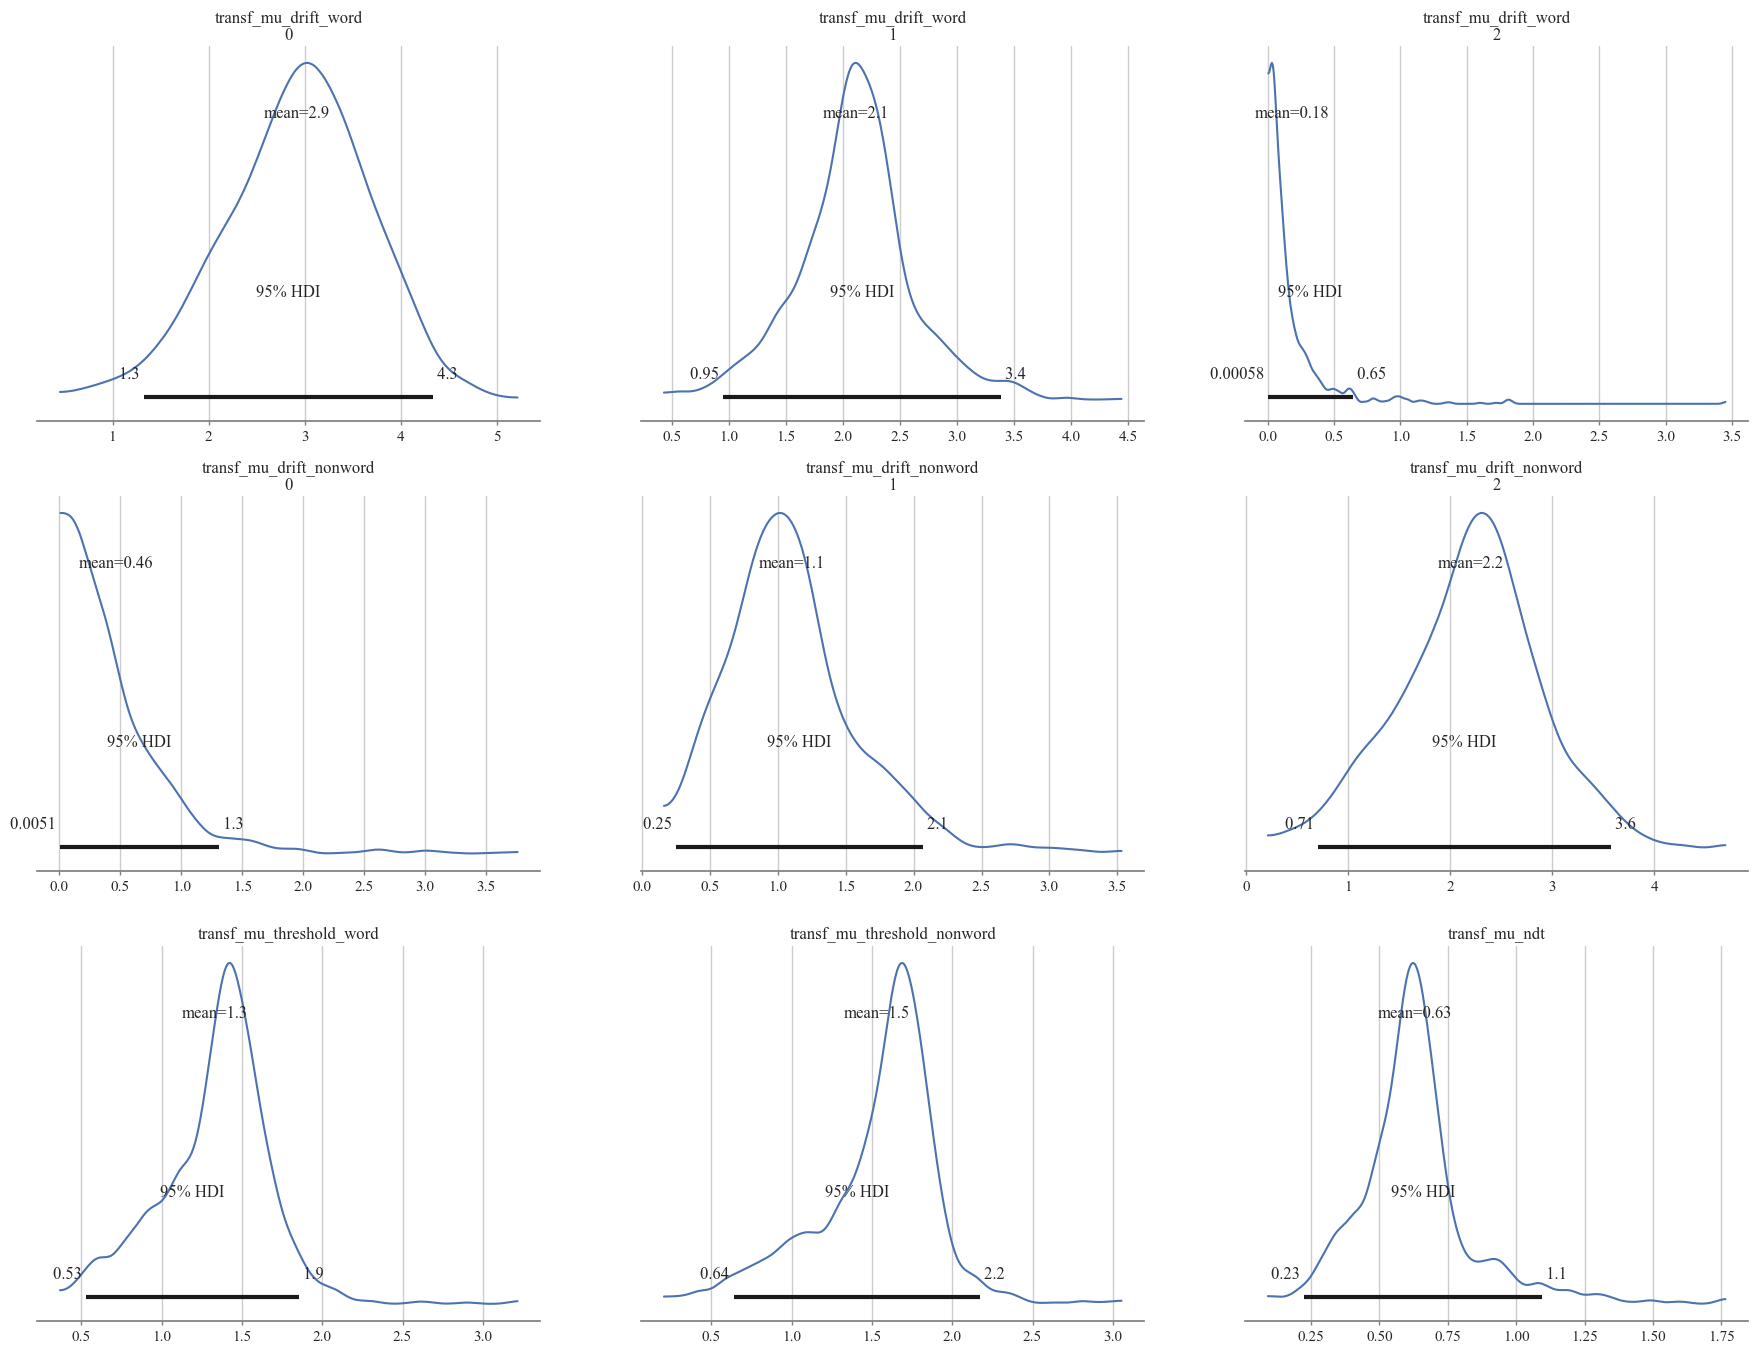

In [22]:
az.plot_posterior(fit, var_names=model_config['transf_params'], hdi_prob=.95);
plt.savefig(plots_path + 'Parameters.pdf')

Loading model parameters for each trial

In [23]:
drift_word_t = fit.stan_variables()['drift_word_t']
drift_nonword_t = fit.stan_variables()['drift_nonword_t']
if model_config['model_name'] != "RDM":
    threshold_t_word = fit.stan_variables()['threshold_t_word']
    threshold_t_nonword = fit.stan_variables()['threshold_t_nonword']
else:
    threshold_t = fit.stan_variables()['threshold_t']
ndt_t = fit.stan_variables()['ndt_t']

#### Models mean parameters in different conditions

In [24]:
HF_condition_w = drift_word_t[:, behavioural_df['category']=="HF"]
HF_condition_nw = drift_nonword_t[:, behavioural_df['category']=="HF"]
LF_condition_w = drift_word_t[:, behavioural_df['category']=="LF"]
LF_condition_nw = drift_nonword_t[:, behavioural_df['category']=="LF"]
NW_condition_w = drift_word_t[:, behavioural_df['category']=="NW"]
NW_condition_nw = drift_nonword_t[:, behavioural_df['category']=="NW"]

In [25]:
print('HF words, word drift mean and std:')
print(np.mean(np.mean(HF_condition_w, axis=1)), np.std(np.mean(HF_condition_w, axis=1)))
print('HF words, nonword drift mean and std:')
print(np.mean(np.mean(HF_condition_nw, axis=1)), np.std(np.mean(HF_condition_nw, axis=1)))
print('LF words word drift mean and std:')
print(np.mean(np.mean(LF_condition_w, axis=1)), np.std(np.mean(LF_condition_w, axis=1)))
print('LF words nonword drift mean and std:')
print(np.mean(np.mean(LF_condition_nw, axis=1)), np.std(np.mean(LF_condition_nw, axis=1)))
print('NW words word drift mean and std:')
print(np.mean(np.mean(NW_condition_w, axis=1)), np.std(np.mean(NW_condition_w, axis=1)))
print('NW words nonword drift mean and std:')
print(np.mean(np.mean(NW_condition_nw, axis=1)), np.std(np.mean(NW_condition_nw, axis=1)))

HF words, word drift mean and std:
3.2612171536046506 0.15649818892189096
HF words, nonword drift mean and std:
0.33233525727916574 0.2269348686855049
LF words word drift mean and std:
2.1690394089304808 0.1365952158077093
LF words nonword drift mean and std:
1.003613069326203 0.17478473388526133
NW words word drift mean and std:
0.07496090850865053 0.06209860847675869
NW words nonword drift mean and std:
2.450292873197833 0.11916882578259


In [26]:
if model_config['model_name'] != "RDM":
    HF_condition_w = threshold_t_word[:, behavioural_df['category']=="HF"]
    HF_condition_nw = threshold_t_nonword[:, behavioural_df['category']=="HF"]
    LF_condition_w = threshold_t_word[:, behavioural_df['category']=="LF"]
    LF_condition_nw = threshold_t_nonword[:, behavioural_df['category']=="LF"]
    NW_condition_w = threshold_t_word[:, behavioural_df['category']=="NW"]
    NW_condition_nw = threshold_t_nonword[:, behavioural_df['category']=="NW"]
else:
    HF_condition = threshold_t[:, behavioural_df['category']=="HF"]
    LF_condition = threshold_t[:, behavioural_df['category']=="LF"]
    NW_condition = threshold_t[:, behavioural_df['category']=="NW"]

In [27]:
if model_config['model_name'] != "RDM":
    print('HF words, word threshold mean and std:')
    print(np.mean(np.mean(HF_condition_w, axis=1)), np.std(np.mean(HF_condition_w, axis=1)))
    print('HF words, nonword threshold mean and std:')
    print(np.mean(np.mean(HF_condition_nw, axis=1)), np.std(np.mean(HF_condition_nw, axis=1)))
    print('LF words word threshold mean and std:')
    print(np.mean(np.mean(LF_condition_w, axis=1)), np.std(np.mean(LF_condition_w, axis=1)))
    print('LF words nonword threshold mean and std:')
    print(np.mean(np.mean(LF_condition_nw, axis=1)), np.std(np.mean(LF_condition_nw, axis=1)))
    print('NW words word threshold mean and std:')
    print(np.mean(np.mean(NW_condition_w, axis=1)), np.std(np.mean(NW_condition_w, axis=1)))
    print('NW words nonword threshold mean and std:')
    print(np.mean(np.mean(NW_condition_nw, axis=1)), np.std(np.mean(NW_condition_nw, axis=1)))
else:
    print('HF words, threshold mean and std:')
    print(np.mean(np.mean(HF_condition, axis=1)), np.std(np.mean(HF_condition, axis=1)))
    print('LF words, threshold mean and std:')
    print(np.mean(np.mean(LF_condition, axis=1)), np.std(np.mean(LF_condition, axis=1)))
    print('NW words, word threshold mean and std:')
    print(np.mean(np.mean(NW_condition, axis=1)), np.std(np.mean(NW_condition, axis=1)))

HF words, word threshold mean and std:
1.4763199933139535 0.08359194559027208
HF words, nonword threshold mean and std:
1.717201435639535 0.09329769249222501
LF words word threshold mean and std:
1.4749701719251336 0.08349045678520263
LF words nonword threshold mean and std:
1.7167877506951872 0.09327203138181768
NW words word threshold mean and std:
1.4750917672357724 0.08349802570804483
NW words nonword threshold mean and std:
1.716825016476965 0.09327263996094041


In [28]:
HF_condition = ndt_t[:, behavioural_df['category']=="HF"]
LF_condition = ndt_t[:, behavioural_df['category']=="LF"]
NW_condition = ndt_t[:, behavioural_df['category']=="NW"]

In [29]:
print('HF words ndt_t mean and std:')
print(np.mean(np.mean(HF_condition, axis=1)), np.std(np.mean(HF_condition, axis=1)))
print('LF words ndt_t mean and std:')
print(np.mean(np.mean(LF_condition, axis=1)), np.std(np.mean(LF_condition, axis=1)))
print('Non Words ndt_t mean and std:')
print(np.mean(np.mean(NW_condition, axis=1)), np.std(np.mean(NW_condition, axis=1)))

HF words ndt_t mean and std:
0.2724805460697674 0.018016278381072785
LF words ndt_t mean and std:
0.27264703063636364 0.017904241707895188
Non Words ndt_t mean and std:
0.2726320332872629 0.017914000976343117


## Calculating metrics

In [30]:
log_likelihood = fit.stan_variables()['log_lik']
print(calculate_waic(log_likelihood))

{'lppd': -225.90694853769145, 'p_waic': 16.488678266640328, 'waic': 484.79125360866357, 'waic_se': 62.40513831855714}


## Simulating RDM with estimated parameters

Simulating RDM with estimated parameters

In [31]:
if model_config['model_name'] != "RDM":
    pp_rt, pp_response = random_rdm_2A(drift_word_t, drift_nonword_t, threshold_t_word, threshold_t_nonword, ndt_t, noise_constant=1, dt=0.001, max_rt=5)
else:
    pp_rt, pp_response = random_rdm_2A(drift_word_t, drift_nonword_t, threshold_t, threshold_t, ndt_t, noise_constant=1, dt=0.001, max_rt=5)

In [32]:
# Predicted Data
tmp1 = pd.DataFrame(pp_rt,
                    index=pd.Index(np.arange(1, len(pp_rt)+1), name='sample'),
                    columns=pd.MultiIndex.from_product((['rt'],
                                                        np.arange(pp_rt.shape[1])),
                                                        names=['variable', 'trial']))
tmp2 = pd.DataFrame(pp_response,
                    index=pd.Index(np.arange(1, len(pp_response)+1), name='sample'),
                    columns=pd.MultiIndex.from_product((['response'],
                                                        np.arange(pp_response.shape[1])),
                                                               names=['variable', 'trial']))
predictedData = pd.concat((tmp1, tmp2), axis=1)

## RT Quantiles Posterior Predictions Checks

In [33]:
quantiles = [.1, .3, .5, .7, .9]

### All Trials

In [34]:
exp_all_trials, pred_all_trials = get_dfs(behavioural_df, predictedData)

In [35]:
all_quantiles_ex = exp_all_trials['rt'].quantile(quantiles)
all_quantiles_pred = pred_all_trials.quantile(quantiles, axis=1).T
all_predicted_bci = np.array([bci(all_quantiles_pred[x]) for x in quantiles])

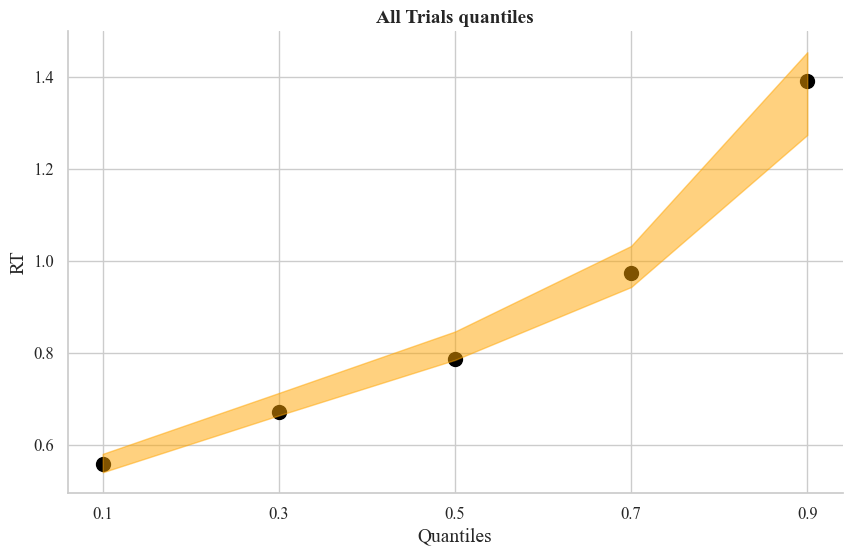

In [36]:
fig, ax = plt.subplots(figsize=(10,6))
plt.subplots_adjust(wspace=0.2, hspace=0.5)

ax.set_title('All Trials quantiles', fontweight="bold", size=14)
ax.scatter(quantiles, all_quantiles_ex, color='black', s=100)

ax.fill_between(quantiles,
                all_predicted_bci[:, 0],
                all_predicted_bci[:, 1],
                all_predicted_bci[:, 0] < all_predicted_bci[:, 1],  color = 'orange', alpha=0.5)

ax.set_xlabel('Quantiles', fontsize=14)
ax.set_xticks(quantiles)
ax.set_xticklabels(quantiles)
ax.set_ylabel('RT', fontsize=14)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(12)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(12) 

sns.despine()
plt.savefig(plots_path + 'PPC-Quantiles-All Trials.pdf')

### All Trials (word response vs non-word response)

In [37]:
exp_word_resp_all, pred_word_resp_all = get_dfs(behavioural_df, predictedData,
                                                response=1)
exp_nonword_resp_all, pred_nonword_resp_all = get_dfs(behavioural_df, predictedData,
                                                      response=0)

In [38]:
word_quantiles_ex = exp_word_resp_all['rt'].quantile(quantiles)
nonword_quantiles_ex = exp_nonword_resp_all['rt'].quantile(quantiles)

word_quantiles_pred = pred_word_resp_all.quantile(quantiles, axis=1).T
nonword_quantiles_pred = pred_nonword_resp_all.quantile(quantiles, axis=1).T

word_predicted_bci = np.array([bci(word_quantiles_pred[x]) for x in quantiles])
nonword_predicted_bci = np.array([bci(nonword_quantiles_pred[x]) for x in quantiles])

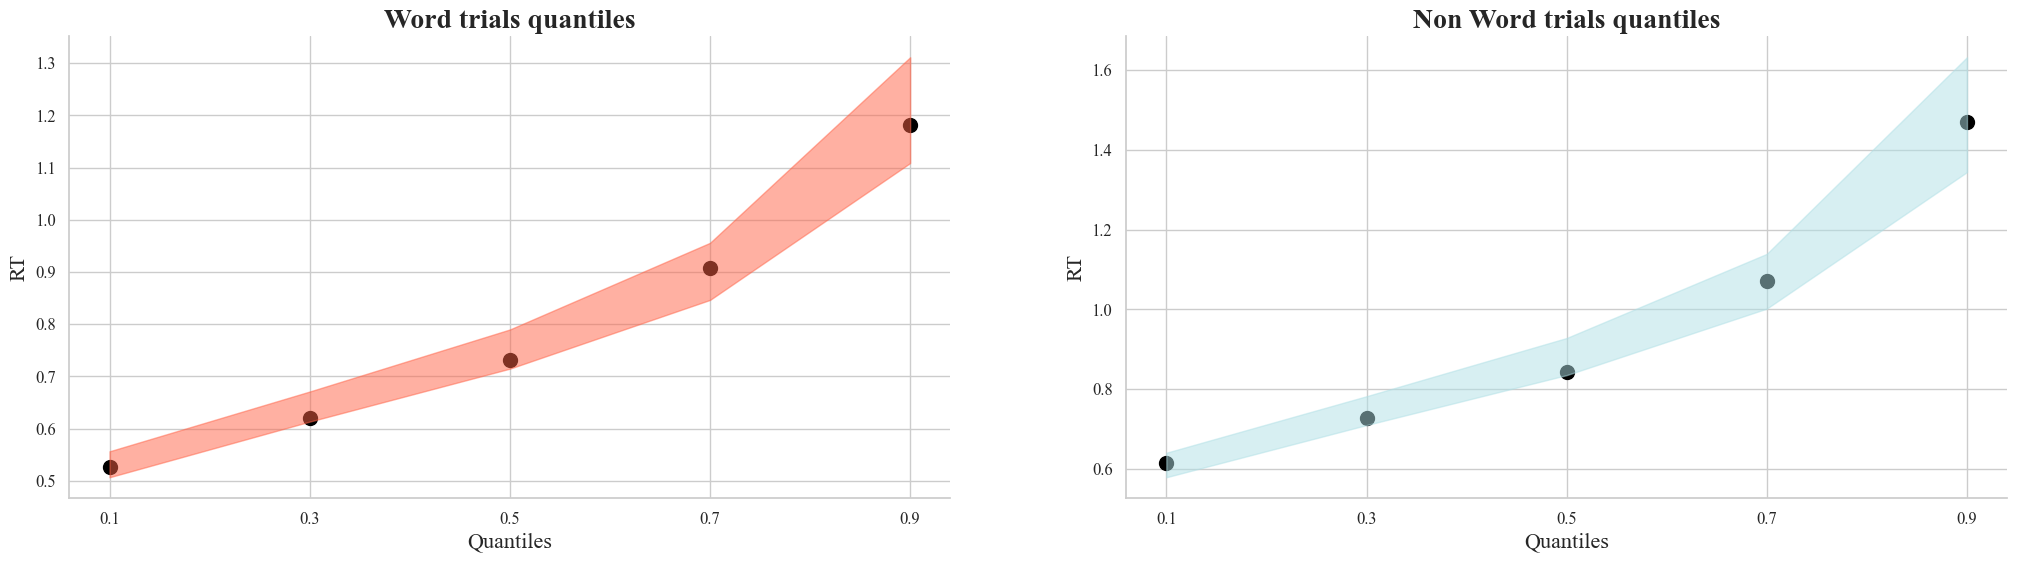

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(25,6))
plt.subplots_adjust(wspace=0.2, hspace=0.5)

axes[0].set_title('Word trials quantiles', fontweight="bold", size=20)
axes[1].set_title('Non Word trials quantiles', fontweight="bold", size=20)

axes[0].scatter(quantiles, word_quantiles_ex, color='black', s=100)
axes[1].scatter(quantiles, nonword_quantiles_ex, color='black', s=100)

axes[0].fill_between(quantiles,
                word_predicted_bci[:, 0],
                word_predicted_bci[:, 1],
                word_predicted_bci[:, 0] < word_predicted_bci[:, 1],  color = 'tomato', alpha=0.5)

axes[1].fill_between(quantiles,
                nonword_predicted_bci[:, 0],
                nonword_predicted_bci[:, 1],
                nonword_predicted_bci[:, 0] < nonword_predicted_bci[:, 1],  color = 'powderblue', alpha=0.5)

for ax in axes:
        ax.set_xlabel('Quantiles', fontsize=16)
        ax.set_xticks(quantiles)
        ax.set_xticklabels(quantiles)
        ax.set_ylabel('RT', fontsize=16)
        for tick in ax.xaxis.get_major_ticks():
            tick.label1.set_fontsize(12)
        for tick in ax.yaxis.get_major_ticks():
            tick.label1.set_fontsize(12) 

sns.despine()
plt.savefig(plots_path + 'PPC-Quantiles-All Trials-Word vs Nonword.pdf')

### All trials (Correct Choice vs Incorrect Choice) 

In [40]:
exp_cor_choice_all, _ = get_dfs(behavioural_df, predictedData,
                                accuracy=1)
exp_incor_resp_all, _ = get_dfs(behavioural_df, predictedData,
                                accuracy=0)
pred_cor_choice_all = predictedData['rt'][predictedData['response']==behavioural_df['label']]
pred_incor_choice_all = predictedData['rt'][predictedData['response']!=behavioural_df['label']]

In [41]:
cor_quantiles_ex = exp_cor_choice_all['rt'].quantile(quantiles)
incor_quantiles_ex = exp_incor_resp_all['rt'].quantile(quantiles)

cor_quantiles_pred = pred_cor_choice_all.quantile(quantiles, axis=1).T
incor_quantiles_pred = pred_incor_choice_all.quantile(quantiles, axis=1).T

cor_predicted_bci = np.array([bci(cor_quantiles_pred[x]) for x in quantiles])
incor_predicted_bci = np.array([bci(incor_quantiles_pred[x]) for x in quantiles])

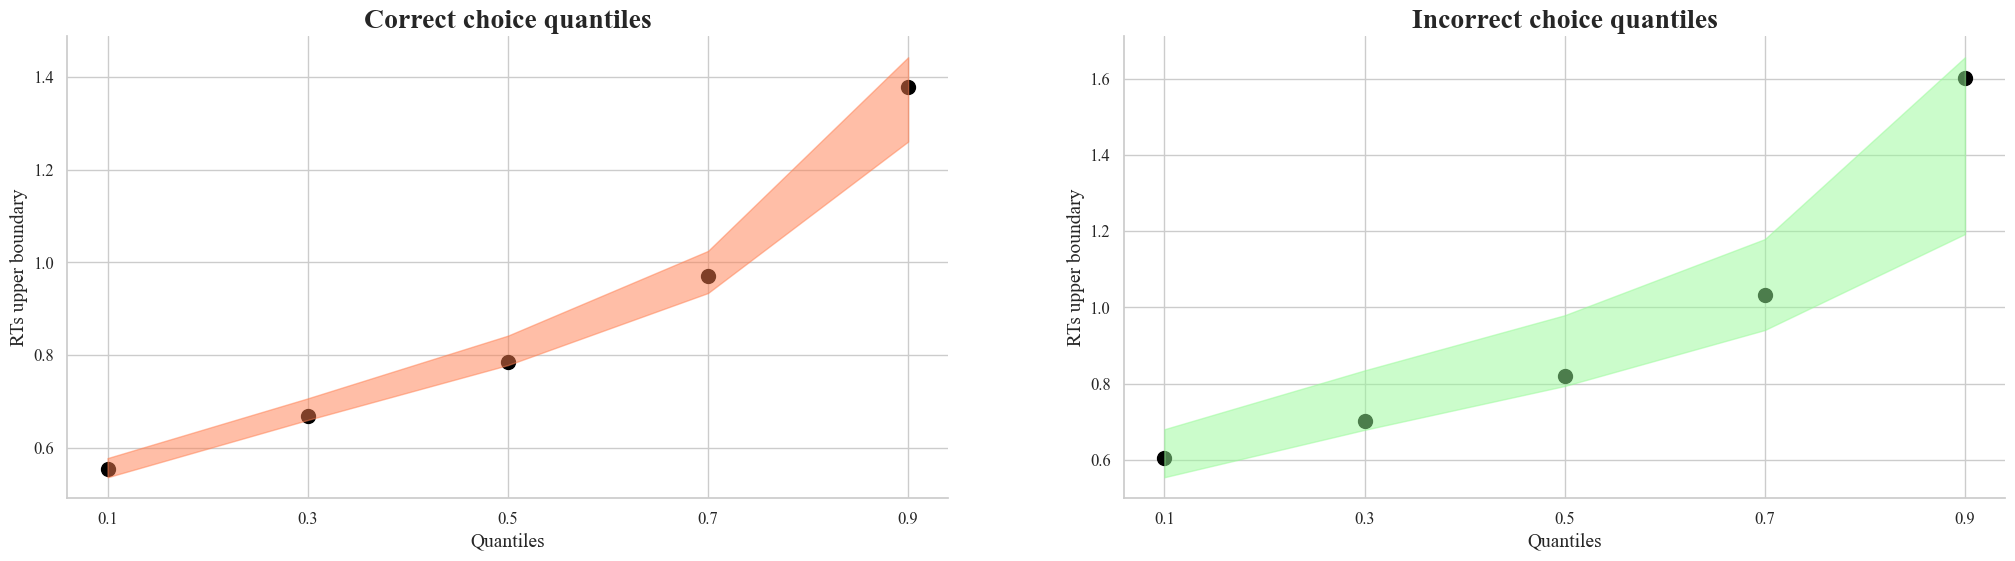

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(25,6))
plt.subplots_adjust(wspace=0.2, hspace=0.5)

axes[0].set_title('Correct choice quantiles', fontweight="bold", size=20)
axes[1].set_title('Incorrect choice quantiles', fontweight="bold", size=20)

axes[0].scatter(quantiles, cor_quantiles_ex, color='black', s=100)
axes[1].scatter(quantiles, incor_quantiles_ex, color='black', s=100)

axes[0].fill_between(quantiles,
                cor_predicted_bci[:, 0],
                cor_predicted_bci[:, 1],
                cor_predicted_bci[:, 0] < cor_predicted_bci[:, 1],  color = 'coral', alpha=0.5)

axes[1].fill_between(quantiles,
                incor_predicted_bci[:, 0],
                incor_predicted_bci[:, 1],
                incor_predicted_bci[:, 0] < incor_predicted_bci[:, 1],  color = 'palegreen', alpha=0.5)

for ax in axes:
        ax.set_xlabel('Quantiles', fontsize=14)
        ax.set_xticks(quantiles)
        ax.set_xticklabels(quantiles)
        ax.set_ylabel('RTs upper boundary', fontsize=14)
        for tick in ax.xaxis.get_major_ticks():
            tick.label1.set_fontsize(12)
        for tick in ax.yaxis.get_major_ticks():
            tick.label1.set_fontsize(12) 

sns.despine()
plt.savefig(plots_path + 'PPC-Quantiles-All Trials-Correct vs Incorrect.pdf')

### Conditional (HF, LF, NW trials)

In [43]:
exp_HF_trials, pred_HF_trials = get_dfs(behavioural_df, predictedData,
                                        category="HF")
exp_LF_trials, pred_LF_trials = get_dfs(behavioural_df, predictedData,
                                        category="LF")
exp_NW_trials, pred_NW_trials = get_dfs(behavioural_df, predictedData,
                                        category="NW")

In [44]:
# experiment Data quantile
HF_quantile_ex = exp_HF_trials['rt'].quantile(quantiles)
LF_quantile_ex = exp_LF_trials['rt'].quantile(quantiles)
NW_quantile_ex = exp_NW_trials['rt'].quantile(quantiles)

# predicted data quantiles (for each sample)
HF_quantile_pred = pred_HF_trials.quantile(quantiles, axis=1).T
LF_quantile_pred = pred_LF_trials.quantile(quantiles, axis=1).T
NW_quantile_pred = pred_NW_trials.quantile(quantiles, axis=1).T

# predicted data quantiles bci
HF_predicted_bci = np.array([bci(HF_quantile_pred[x]) for x in quantiles])
LF_predicted_bci = np.array([bci(LF_quantile_pred[x]) for x in quantiles])
NW_predicted_bci = np.array([bci(NW_quantile_pred[x]) for x in quantiles])

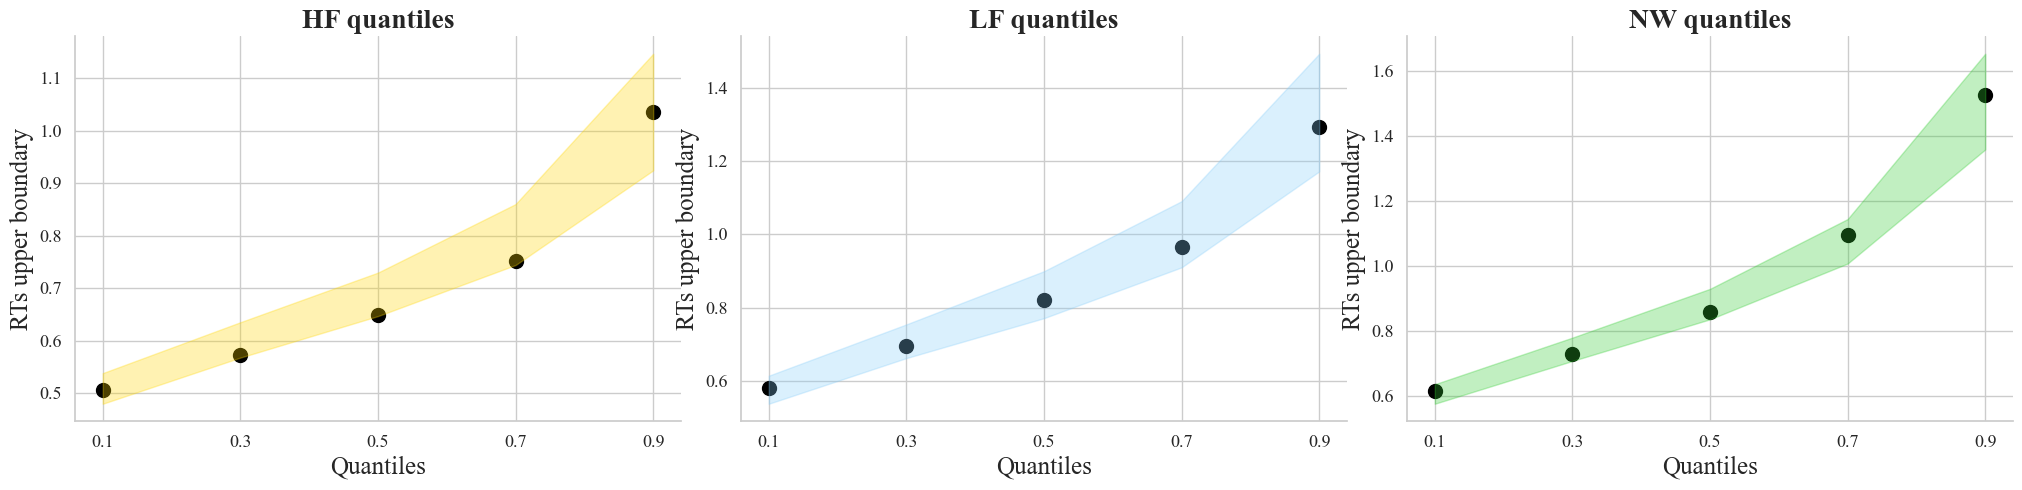

In [45]:
fig, axes = plt.subplots(1,3 , figsize=(25,5))
plt.subplots_adjust(wspace=0.1, hspace=0.5)

axes[0].set_title('HF quantiles', fontweight="bold", size=20)
axes[1].set_title('LF quantiles', fontweight="bold", size=20)
axes[2].set_title('NW quantiles', fontweight="bold", size=20)

axes[0].scatter(quantiles, HF_quantile_ex, color='black', s=100)
axes[1].scatter(quantiles, LF_quantile_ex, color='black', s=100)
axes[2].scatter(quantiles, NW_quantile_ex, color='black', s=100)

axes[0].fill_between(quantiles,
                HF_predicted_bci[:, 0],
                HF_predicted_bci[:, 1],
                HF_predicted_bci[:, 0] < HF_predicted_bci[:, 1],  color = 'gold', alpha=0.3)

axes[1].fill_between(quantiles,
                LF_predicted_bci[:, 0],
                LF_predicted_bci[:, 1],
                LF_predicted_bci[:, 0] < LF_predicted_bci[:, 1],  color = 'lightskyblue', alpha=0.3)

axes[2].fill_between(quantiles,
                NW_predicted_bci[:, 0],
                NW_predicted_bci[:, 1],
                NW_predicted_bci[:, 0] < NW_predicted_bci[:, 1],  color = 'limegreen', alpha=0.3)


for ax in axes:
        ax.set_xlabel('Quantiles', fontsize=18)
        ax.set_xticks(quantiles)
        ax.set_xticklabels(quantiles)
        ax.set_ylabel('RTs upper boundary', fontsize=18)
        for tick in ax.xaxis.get_major_ticks():
                tick.label1.set_fontsize(13)
        for tick in ax.yaxis.get_major_ticks():
            tick.label1.set_fontsize(13) 

sns.despine()
plt.savefig(plots_path + 'PPC-Quantiles-Conditional.pdf')

### Conditional (HF, LF, NW trials) for word response and nonword response

In [46]:
exp_word_resp_HF, pred_word_resp_HF = get_dfs(behavioural_df, predictedData,
                                              category="HF", response=1)
exp_word_resp_LF, pred_word_resp_LF = get_dfs(behavioural_df, predictedData,
                                              category="LF", response=1)
exp_word_resp_NW, pred_word_resp_NW = get_dfs(behavioural_df, predictedData,
                                              category="NW", response=1)

exp_nonword_resp_HF, pred_nonword_resp_HF = get_dfs(behavioural_df, predictedData,
                                                    category="HF", response=0)
exp_nonword_resp_LF, pred_nonword_resp_LF = get_dfs(behavioural_df, predictedData,
                                                    category="LF", response=0)
exp_nonword_resp_NW, pred_nonword_resp_NW = get_dfs(behavioural_df, predictedData,
                                                    category="NW", response=0)

In [47]:
# experiment Data quantile
HF_word_quantile_ex = exp_word_resp_HF['rt'].quantile(quantiles)
LF_word_quantile_ex = exp_word_resp_LF['rt'].quantile(quantiles)
NW_word_quantile_ex = exp_word_resp_NW['rt'].quantile(quantiles)

HF_nonword_quantile_ex = exp_nonword_resp_HF['rt'].quantile(quantiles)
LF_nonword_quantile_ex = exp_nonword_resp_LF['rt'].quantile(quantiles)
NW_nonword_quantile_ex = exp_nonword_resp_NW['rt'].quantile(quantiles)

# predicted data quantiles (for each sample)
HF_word_quantile_pred = pred_word_resp_HF.quantile(quantiles, axis=1).T
LF_word_quantile_pred = pred_word_resp_LF.quantile(quantiles, axis=1).T
NW_word_quantile_pred = pred_word_resp_NW.quantile(quantiles, axis=1).T

HF_nonword_quantile_pred = pred_nonword_resp_HF.quantile(quantiles, axis=1).T
LF_nonword_quantile_pred = pred_nonword_resp_LF.quantile(quantiles, axis=1).T
NW_nonword_quantile_pred = pred_nonword_resp_NW.quantile(quantiles, axis=1).T


# predicted data quantiles bci
HF_word_predicted_bci = np.array([bci(HF_word_quantile_pred[x]) for x in quantiles])
LF_word_predicted_bci = np.array([bci(LF_word_quantile_pred[x]) for x in quantiles])
NW_word_predicted_bci = np.array([bci(NW_word_quantile_pred[x]) for x in quantiles])

HF_nonword_predicted_bci = np.array([bci(HF_nonword_quantile_pred[x]) for x in quantiles])
LF_nonword_predicted_bci = np.array([bci(LF_nonword_quantile_pred[x]) for x in quantiles])
NW_nonword_predicted_bci = np.array([bci(NW_nonword_quantile_pred[x]) for x in quantiles])

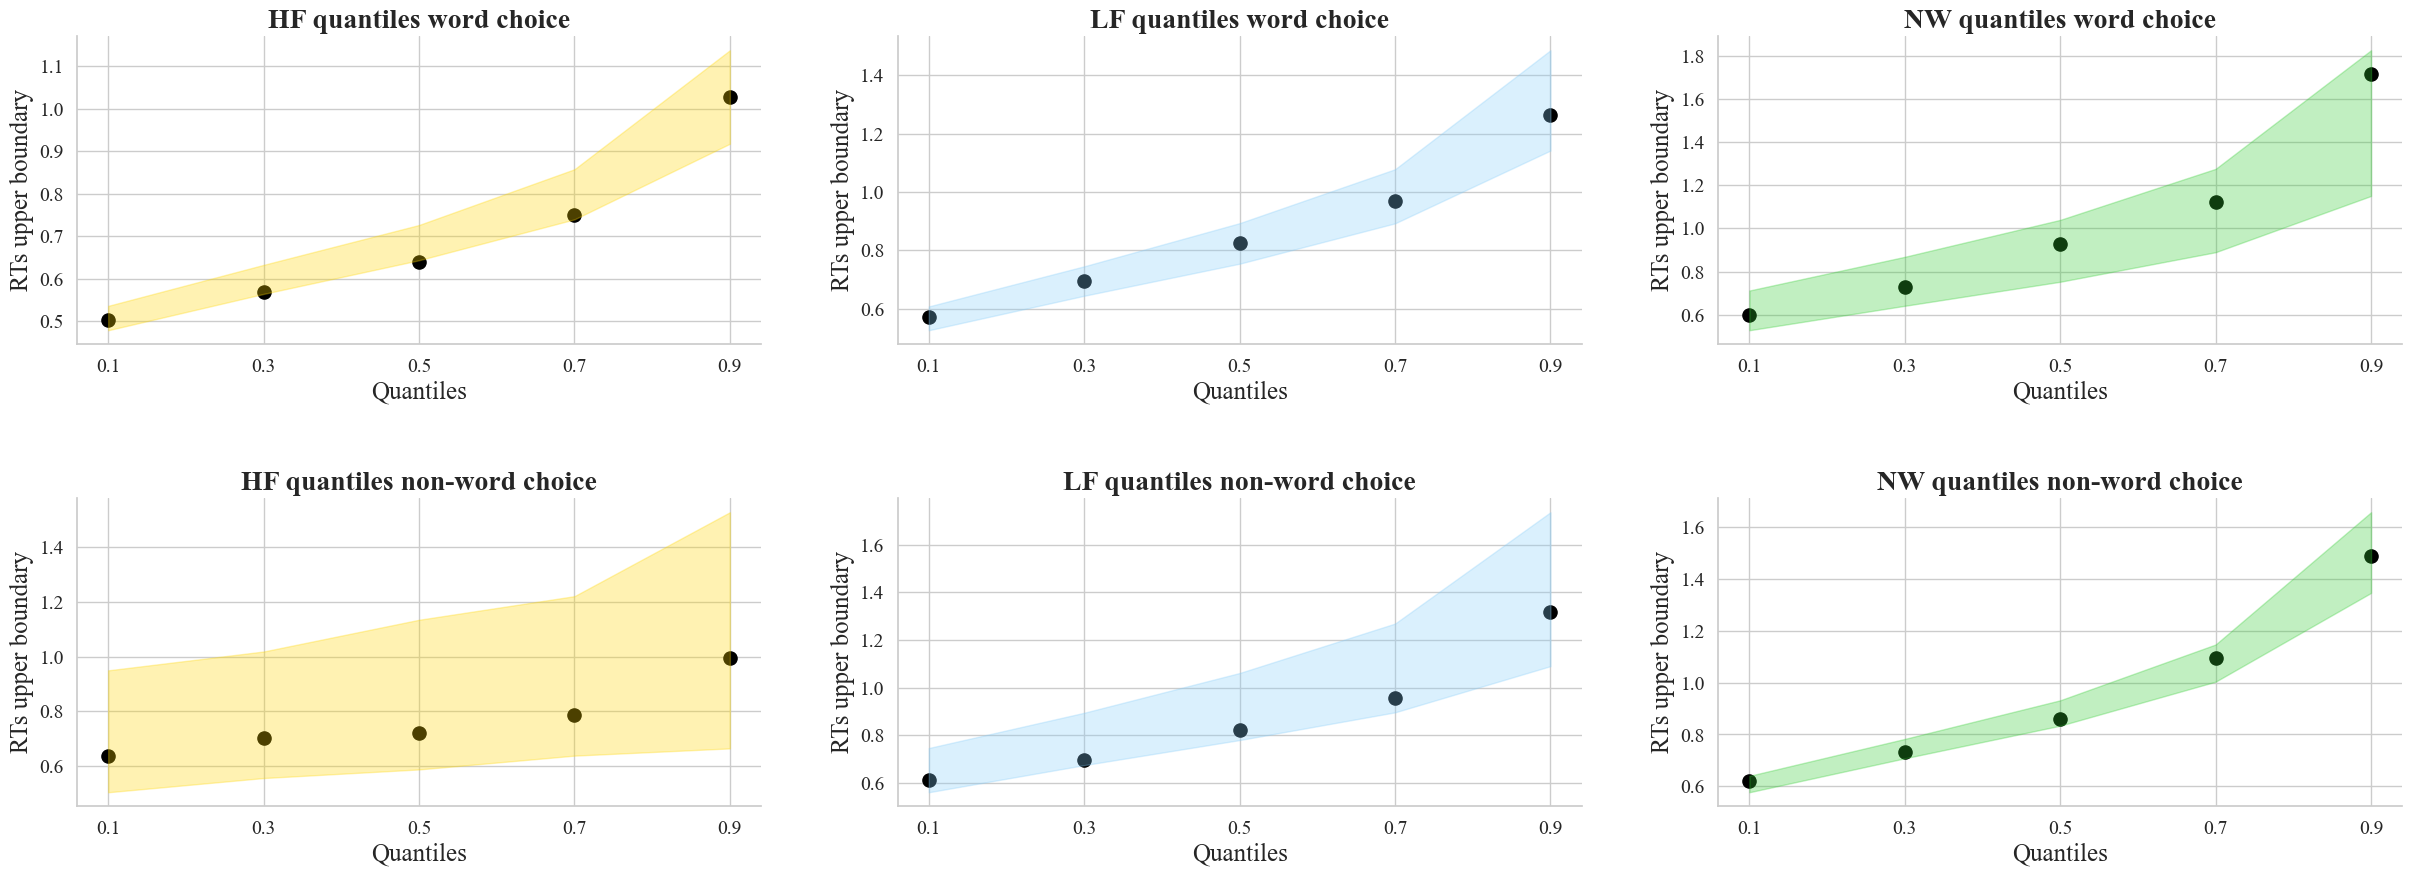

In [48]:
fig, axes = plt.subplots(2,3 , figsize=(30,10))
plt.subplots_adjust(wspace=0.2, hspace=0.5)

axes[0][0].set_title('HF quantiles word choice', fontweight="bold", size=20)
axes[0][1].set_title('LF quantiles word choice', fontweight="bold", size=20)
axes[0][2].set_title('NW quantiles word choice', fontweight="bold", size=20)

axes[1][0].set_title('HF quantiles non-word choice', fontweight="bold", size=20)
axes[1][1].set_title('LF quantiles non-word choice', fontweight="bold", size=20)
axes[1][2].set_title('NW quantiles non-word choice', fontweight="bold", size=20)

axes[0][0].scatter(quantiles, HF_word_quantile_ex, color='black', s=90)
axes[0][1].scatter(quantiles, LF_word_quantile_ex, color='black', s=90)
axes[0][2].scatter(quantiles, NW_word_quantile_ex, color='black', s=90)

axes[1][0].scatter(quantiles, HF_nonword_quantile_ex, color='black', s=90)
axes[1][1].scatter(quantiles, LF_nonword_quantile_ex, color='black', s=90)
axes[1][2].scatter(quantiles, NW_nonword_quantile_ex, color='black', s=90)


axes[0][0].fill_between(quantiles,
                HF_word_predicted_bci[:, 0],
                HF_word_predicted_bci[:, 1],
                HF_word_predicted_bci[:, 0] < HF_word_predicted_bci[:, 1],  color = 'gold', alpha=0.3)

axes[0][1].fill_between(quantiles,
                LF_word_predicted_bci[:, 0],
                LF_word_predicted_bci[:, 1],
                LF_word_predicted_bci[:, 0] < LF_word_predicted_bci[:, 1],  color = 'lightskyblue', alpha=0.3)

axes[0][2].fill_between(quantiles,
                NW_word_predicted_bci[:, 0],
                NW_word_predicted_bci[:, 1],
                NW_word_predicted_bci[:, 0] < NW_word_predicted_bci[:, 1],  color = 'limegreen', alpha=0.3)


axes[1][0].fill_between(quantiles,
                HF_nonword_predicted_bci[:, 0],
                HF_nonword_predicted_bci[:, 1],
                HF_nonword_predicted_bci[:, 0] < HF_nonword_predicted_bci[:, 1],  color = 'gold', alpha=0.3)

axes[1][1].fill_between(quantiles,
                LF_nonword_predicted_bci[:, 0],
                LF_nonword_predicted_bci[:, 1],
                LF_nonword_predicted_bci[:, 0] < LF_nonword_predicted_bci[:, 1],  color = 'lightskyblue', alpha=0.3)

axes[1][2].fill_between(quantiles,
                NW_nonword_predicted_bci[:, 0],
                NW_nonword_predicted_bci[:, 1],
                NW_nonword_predicted_bci[:, 0] < NW_nonword_predicted_bci[:, 1],  color = 'limegreen', alpha=0.3)


for ax_d1 in axes:
    for ax in ax_d1:
        ax.set_xlabel('Quantiles', fontsize=18)
        ax.set_xticks(quantiles)
        ax.set_xticklabels(quantiles)
        ax.set_ylabel('RTs upper boundary', fontsize=18)
        for tick in ax.xaxis.get_major_ticks():
                tick.label1.set_fontsize(14)
        for tick in ax.yaxis.get_major_ticks():
            tick.label1.set_fontsize(14) 

sns.despine()
plt.savefig(plots_path + 'PPC-Quantiles-Conditional-Word vs Nonword.pdf')

## Mean Accuracy and RT Posterior Prediction Checks


### All trials

In [49]:
exp_all_trials_rt, pred_all_trials_rt = get_dfs(behavioural_df, predictedData)
exp_all_trials_resp, pred_all_trials_resp = get_dfs(behavioural_df, predictedData,
                                                    pred_df_type='response')

In [50]:
all_data_rt_mean = exp_all_trials_rt['rt'].mean()
all_pred_rt_mean = pred_all_trials_rt.mean(axis=1)

all_data_resp_mean = exp_all_trials_resp['response'].mean()
all_pred_resp_mean = pred_all_trials_resp.mean(axis=1)

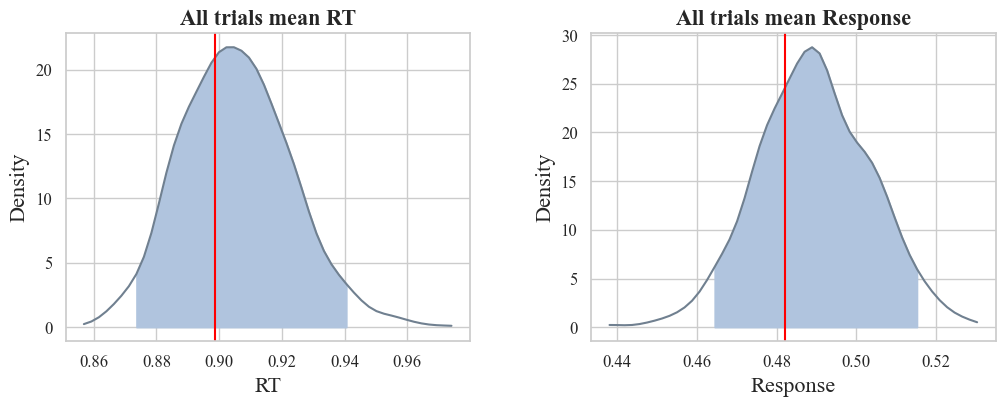

In [51]:
fig, axes = plt.subplots(1,2 , figsize=(12, 4))
plt.subplots_adjust(wspace=0.3, hspace=0.5)

axes[0].set_title('All trials mean RT', fontweight="bold", size=16)
axes[1].set_title('All trials mean Response', fontweight="bold", size=16)

plot_mean_posterior(all_pred_rt_mean, all_data_rt_mean, axes[0])
plot_mean_posterior(all_pred_resp_mean, all_data_resp_mean, axes[1])

axes[0].set_xlabel('RT', fontsize=16)
axes[1].set_xlabel('Response', fontsize=16)

for ax in axes:
        ax.set_ylabel('Density', fontsize=16)
        for tick in ax.xaxis.get_major_ticks():
            tick.label1.set_fontsize(12)
        for tick in ax.yaxis.get_major_ticks():
            tick.label1.set_fontsize(12)
            
plt.savefig(plots_path + 'PPC-Mean Accuracy and RT-All trials.pdf')

### All Trials (correct choice vs incorrect choice)

In [52]:
exp_cor_all_trials_rt, pred_cor_all_trials_rt = get_dfs(behavioural_df, predictedData,
                                                        accuracy=1)
exp_incor_all_trials_rt, pred_incor_all_trials_rt = get_dfs(behavioural_df, predictedData,
                                                            accuracy=0)

exp_cor_all_trials_resp, pred_cor_all_trials_resp = get_dfs(behavioural_df, predictedData,
                                                            accuracy=1, pred_df_type='response')
exp_incor_all_trials_resp, pred_incor_all_trials_resp = get_dfs(behavioural_df, predictedData,
                                                                accuracy=0, pred_df_type='response')

In [53]:
all_trials_cor_rt_mean = exp_cor_all_trials_rt['rt'].mean()
all_pred_cor_rt_mean = pred_cor_all_trials_rt.mean(axis=1)

all_trials_incor_rt_mean = exp_incor_all_trials_rt['rt'].mean()
all_pred_incor_rt_mean = pred_incor_all_trials_rt.mean(axis=1)


all_data_cor_resp_mean = exp_cor_all_trials_resp['response'].mean()
all_pred_cor_resp_mean = pred_cor_all_trials_resp.mean(axis=1)

all_data_incor_resp_mean = exp_incor_all_trials_resp['response'].mean()
all_pred_incor_resp_mean = pred_incor_all_trials_resp.mean(axis=1)

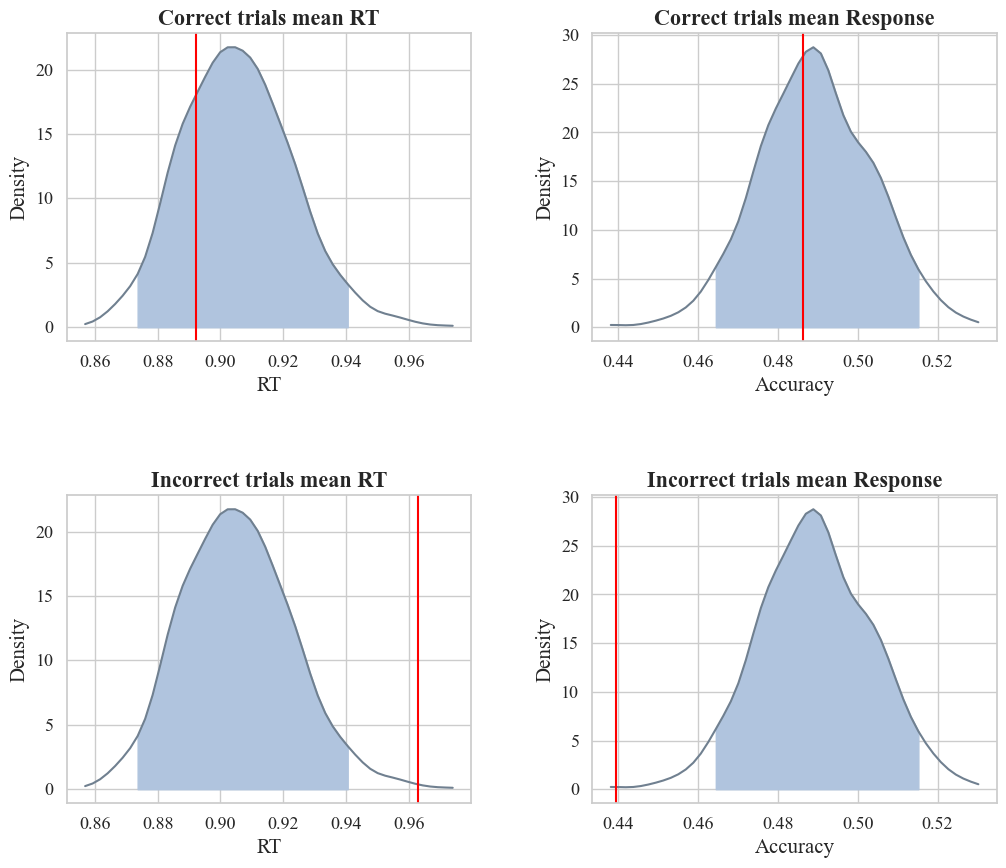

In [54]:
fig, axes = plt.subplots(2,2 , figsize=(12,10))
plt.subplots_adjust(wspace=0.3, hspace=0.5)

axes[0][0].set_title('Correct trials mean RT', fontweight="bold", size=16)
axes[0][1].set_title('Correct trials mean Response', fontweight="bold", size=16)
axes[1][0].set_title('Incorrect trials mean RT', fontweight="bold", size=16)
axes[1][1].set_title('Incorrect trials mean Response', fontweight="bold", size=16)

plot_mean_posterior(all_pred_cor_rt_mean, all_trials_cor_rt_mean, axes[0][0])
plot_mean_posterior(all_pred_cor_resp_mean, all_data_cor_resp_mean, axes[0][1])

plot_mean_posterior(all_pred_incor_rt_mean, all_trials_incor_rt_mean, axes[1][0])
plot_mean_posterior(all_pred_incor_resp_mean, all_data_incor_resp_mean, axes[1][1])

for ax in axes:
        ax[0].set_xlabel('RT', fontsize=15)
        ax[1].set_xlabel('Accuracy', fontsize=15)
        ax[0].set_ylabel('Density', fontsize=15)
        ax[1].set_ylabel('Density', fontsize=15)
        for tick in ax[0].xaxis.get_major_ticks():
            tick.label1.set_fontsize(13)
        for tick in ax[0].yaxis.get_major_ticks():
            tick.label1.set_fontsize(13)
        for tick in ax[1].xaxis.get_major_ticks():
            tick.label1.set_fontsize(13)
        for tick in ax[1].yaxis.get_major_ticks():
            tick.label1.set_fontsize(13) 

plt.savefig(plots_path + 'PPC-Mean Accuracy and RT-All trials-Correct vs Incorrect.pdf')

### Conditional (HF, LF, NW trials) 

In [55]:
exp_HF_trials_rt, pred_HF_trials_rt = get_dfs(behavioural_df, predictedData,
                                              category="HF")
exp_LF_trials_rt, pred_LF_trials_rt = get_dfs(behavioural_df, predictedData,
                                              category="LF")
exp_NW_trials_rt, pred_NW_trials_rt = get_dfs(behavioural_df, predictedData,
                                              category="NW")

exp_HF_trials_resp, pred_HF_trials_resp = get_dfs(behavioural_df, predictedData,
                                                  category="HF", pred_df_type='response')
exp_LF_trials_resp, pred_LF_trials_resp = get_dfs(behavioural_df, predictedData,
                                                  category="LF", pred_df_type='response')
exp_NW_trials_resp, pred_NW_trials_resp = get_dfs(behavioural_df, predictedData,
                                                  category="NW", pred_df_type='response')

In [56]:
HF_data_rt_mean = exp_HF_trials_rt['rt'].mean()
LF_data_rt_mean = exp_LF_trials_rt['rt'].mean()
NW_data_rt_mean = exp_NW_trials_rt['rt'].mean()

HF_pred_rt_mean = pred_HF_trials_rt.mean(axis=1)
LF_pred_rt_mean = pred_LF_trials_rt.mean(axis=1)
NW_pred_rt_mean = pred_NW_trials_rt.mean(axis=1)


HF_data_resp_mean = exp_HF_trials_resp['response'].mean()
LF_data_resp_mean = exp_LF_trials_resp['response'].mean()
NW_data_resp_mean = exp_NW_trials_resp['response'].mean()

HF_pred_resp_mean = pred_HF_trials_resp.mean(axis=1)
LF_pred_resp_mean = pred_LF_trials_resp.mean(axis=1)
NW_pred_resp_mean = pred_NW_trials_resp.mean(axis=1)


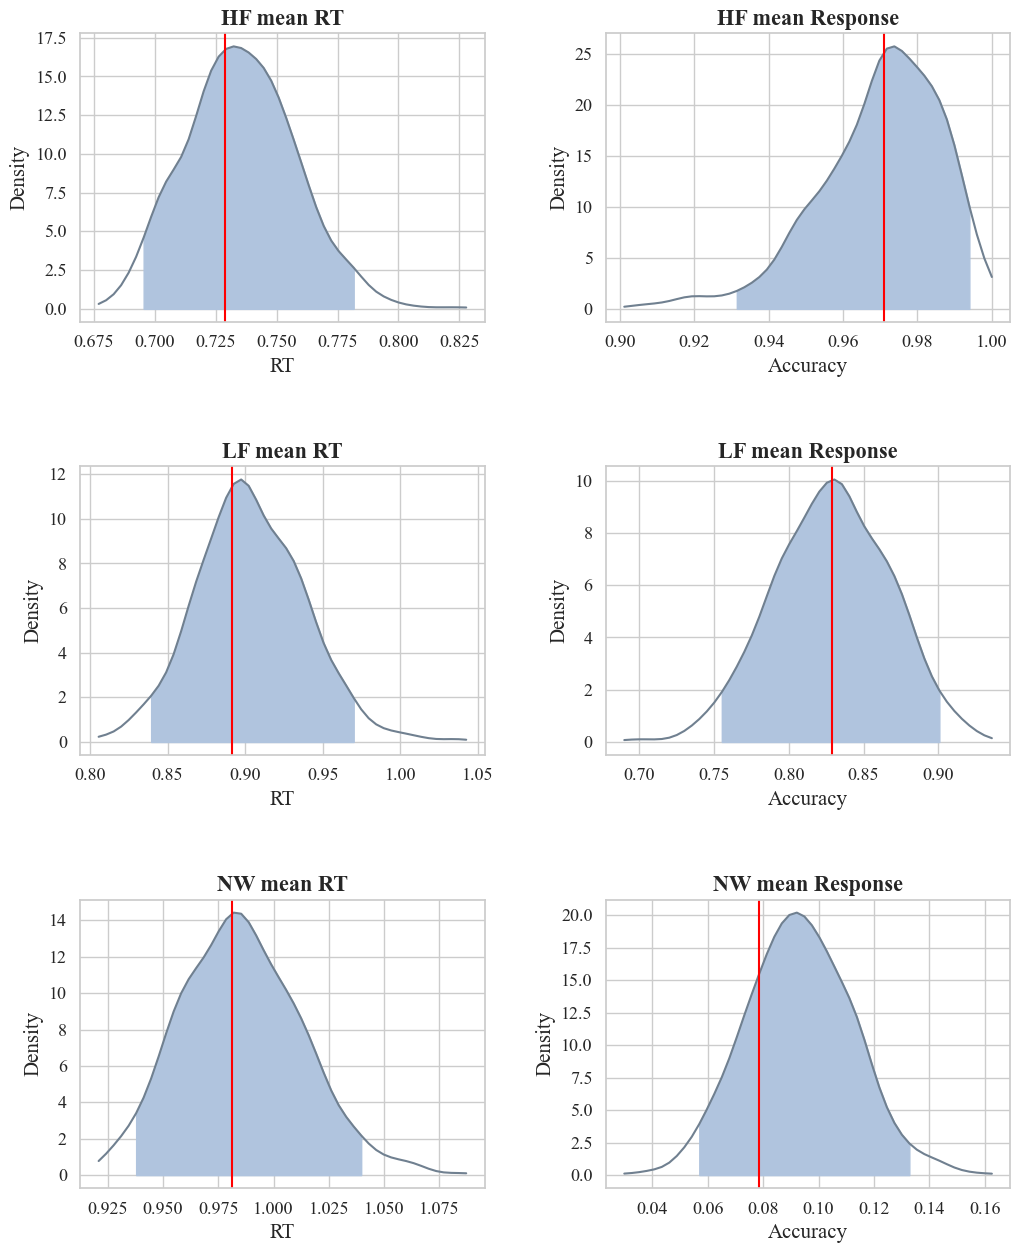

In [57]:
fig, axes = plt.subplots(3,2 , figsize=(12,15))
plt.subplots_adjust(wspace=0.3, hspace=0.5)

axes[0][0].set_title('HF mean RT', fontweight="bold", size=16)
axes[0][1].set_title('HF mean Response', fontweight="bold", size=16)
axes[1][0].set_title('LF mean RT', fontweight="bold", size=16)
axes[1][1].set_title('LF mean Response', fontweight="bold", size=16)
axes[2][0].set_title('NW mean RT', fontweight="bold", size=16)
axes[2][1].set_title('NW mean Response', fontweight="bold", size=16)

plot_mean_posterior(HF_pred_rt_mean, HF_data_rt_mean, axes[0][0])
plot_mean_posterior(HF_pred_resp_mean, HF_data_resp_mean, axes[0][1])

plot_mean_posterior(LF_pred_rt_mean, LF_data_rt_mean, axes[1][0])
plot_mean_posterior(LF_pred_resp_mean, LF_data_resp_mean, axes[1][1])

plot_mean_posterior(NW_pred_rt_mean, NW_data_rt_mean, axes[2][0])
plot_mean_posterior(NW_pred_resp_mean, NW_data_resp_mean, axes[2][1])

for ax in axes:
        ax[0].set_xlabel('RT', fontsize=15)
        ax[1].set_xlabel('Accuracy', fontsize=15)
        ax[0].set_ylabel('Density', fontsize=15)
        ax[1].set_ylabel('Density', fontsize=15)
        for tick in ax[0].xaxis.get_major_ticks():
            tick.label1.set_fontsize(13)
        for tick in ax[0].yaxis.get_major_ticks():
            tick.label1.set_fontsize(13)
        for tick in ax[1].xaxis.get_major_ticks():
            tick.label1.set_fontsize(13)
        for tick in ax[1].yaxis.get_major_ticks():
            tick.label1.set_fontsize(13) 

plt.savefig(plots_path + 'PPC-Mean Accuracy and RT-Conditional.pdf')